# Development of new features for polymerist

In [1]:
import networkx as nx
from rdkit import Chem

import mbuild
from mbuild.compound import Compound
from mbuild.conversion import load, load_smiles, from_rdkit, to_smiles, to_pybel
from mbuild.lib.recipes.polymer import Polymer

comp = mbuild.Compound()

/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/mdtraj/formats/__init__.py:6: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from .xtc import XTCTrajectoryFile
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/mdtraj/geometry/order.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/pkg_resources/__init__.py:2846: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/mbuild/recipes/__i

## Developing monomer graphs

### String/graph translation (SMILES-like)

In [2]:
from typing import ClassVar, Generator, Optional, Sequence, Union
from itertools import product as cartesian_product

from polymerist.genutils.iteration import asiterable
from polymerist.genutils.sequences import bin_ids_forming_sequence
from polymerist.genutils.textual.delimiters import validate_braces 


class MonomerGraph(nx.Graph):
    '''A graph representation of the connectivity of monomer fragments in a polymer topology'''
    MONOMER_NAME_ATTR : ClassVar[str] = 'monomer_name' # node attribute name to assign the name of each monomer to

    # connectivity properties
    @property
    def num_monomers(self) -> int:
        '''Number of monomer units represented in the current polymer'''
        return self.number_of_nodes()
    DOP = num_monomers

    @property
    def is_unbranched(self) -> bool:
        '''Whether the monomer graph represents straight chain(s) without branching'''
        return all(node_deg <= 2 for node_id, node_deg in self.degree)
    is_linear = is_unbranched

    @property
    def is_unbranched(self) -> bool:
        '''Whether the monomer graph represents straight chain(s) without branching'''
        return not self.is_unbranched
    

    # topological and multi-chain settings
    @property
    def num_chains(self) -> int:
        '''The number of disconnected chains represented by the MonoGraph'''
        return nx.number_connected_components(self)

    @property
    def chains(self) -> Generator['MonomerGraph', None, None]:
        '''Generates all disconnected polymers chains in the graph sequentially'''
        for cc_nodes in nx.connected_components(self):
            yield self.subgraph(cc_nodes)

    @property
    def unique_monomer_names(self) -> set[str]:
        '''The collection of unique monomer names embedded in the graph nodes'''
        return set(nx.get_node_attributes(self, self.MONOMER_NAME_ATTR).values())


    # visualization
    def draw(self, show_names : bool=True) -> None: # TODO: expand arg passing (positions, matplotlib axes, etc)
        '''Visualize graph structure with NetworkX'''
        labels = nx.get_node_attributes(self, self.MONOMER_NAME_ATTR) if show_names else None
        nx.draw(self, with_labels=True, labels=labels)
    visualize = draw


    # chemical information checks
    def insert_chemical_info(self, chemical_info : dict[str, dict]) -> None:
        '''Insert SMILES, SMARTS, and atom/linker count info into nodes from minimal set of monomer info templates'''
        raise NotImplemented

    def _validate(self) -> bool:
        '''Check whether the chemical information inserted into the monomer graph is valid'''
        raise NotImplemented


    # SMILES-like in-line encodings
    ## Reading string
    @classmethod
    def from_smidge_string(cls, monostring : str, start_node_idx : int=0) -> 'MonomerGraph':
        '''Parse a SMIDGE ("SMILES-like Monomer Interconnectivity & Degree Graph Encoding") string and read it into a networkX Graph'''
        validate_braces(monostring) # check that all braces are in order before proceeding
        visited : list[int] = []
        curr_idx = start_node_idx - 1
        mononame = ''
        
        monograph = cls() # create empty instance with class initializer
        for char in monostring:
            if char == '[':                                 # 1) if reached a new monomer block...
                mononame = ''                               #   clear the current monomer name
                curr_idx += 1                               #   and advance the current position index
            elif char == ']':                               # 2) if reached the end of a monomer block...
                monograph.add_node(curr_idx, **{cls.MONOMER_NAME_ATTR : mononame}) #   add a new node with the current index and name
                if visited:                                 #   if previously-visited nodes exist...
                    monograph.add_edge(curr_idx, visited.pop())     #   remove the last visited node from the traversal stack and link the current node to it
                visited.append(curr_idx)                    #   add the current node to the stack of visited nodes
            elif char == '(':                               # 3) if beginning a traversal branch...
                visited.append(visited[-1])                 #   duplicate the last visited node
            elif char == ')':                               # 4) if exiting a branch...
                visited.pop()                               #   remove the last visited position and return to the previous most recent visited node
            elif char == '.':                               # 5) if reaching the end of a connected component... | TOSELF: opted for this over str.split('.') as this already tracks node sequence
                visited.clear()                             #   clear the visited stack to restart the traversal for the new component (ensures it is not connected to the previous one)
            else:                                           # 6) otherwise... 
                mononame += char                            #   must be inside a monomer block; in that case, just extend the current name
            
        return monograph
    from_SMIDGE = from_smidge = from_smidge_string

    ## Writing string
    def _validate_start_node_idxs(self : nx.Graph, start_node_idxs : Optional[Union[int, Sequence[int]]]=None) -> dict[int, int]:
        '''Check if a collection of DFS traversal start indices are valid for the current graph topology'''
        # 0) if explicitly NO ids are passed, no validation is needed
        n_chains = self.num_chains
        if start_node_idxs is None:
            return {
                i : min(chain) # assign the smallest node in each component as the starting indices
                    for i, chain in enumerate(self.chains)
            }

        # 1) check that there are enough start nodes for the present number of chains
        start_node_idxs = asiterable(start_node_idxs) # convert to iterable to handle singleton values in a unified way
        n_nodes = len(start_node_idxs)
        if n_nodes != n_chains:
            quantifier = 'few' if (n_nodes < n_chains) else 'many'
            raise ValueError(f'Provided too {quantifier} chain start indices traversal of the given graph ({n_nodes} provided for {n_chains}-chain graph)')

        # 2) check that there exists a 1:1 mapping between the provided node collection and DISTINCT connected components
        possible_cc_orders = bin_ids_forming_sequence(start_node_idxs, nx.connected_components(self), unique_bins=True)
        try:
            cc_order = next(possible_cc_orders)
            return {
                chain_idx : start_node_idx
                    for (chain_idx, start_node_idx) in zip(cc_order, start_node_idxs) # the parity of this is guaranteed by the prior length match check
        }
        except StopIteration:
            raise ValueError('Starting node indices provided do not uniquely correspond to distinct chains')

    def _chain_to_smidge_string(self : nx.Graph, start_node_idx : Optional[int]=None) -> str:
        '''Convert an individual chain in monomer graph into a SMIDGE ("SMILES-like Monomer Interconnectivity & Degree Graph Encoding") string'''
        neighbors = nx.dfs_successors(self, source=start_node_idx) # determine DFS ordering of nodes and their neighbors
        visited = {i : False for i in self.nodes} 
        stack = [start_node_idx]
        
        tokens = []
        while stack:
            curr_idx = stack.pop()
            if not visited[curr_idx]:                                   # 1) collect appropriate tokens for the current node, depending on whether it has already been visited
                mononame = self.nodes[curr_idx][self.MONOMER_NAME_ATTR] # get the name associated with the current monomer node (enclosed in square brackets)
                tokens.append(f'[{mononame}]')                          #   push the current node's monomer label onto the result stack
                visited[curr_idx] = True                                #   and mark as having been visited
            else:                                                       # otherwise, if returning to an already-visited node...
                tokens.append(')')                                      #   close the branch that must have led to this node
                
            if (successors := neighbors.get(curr_idx, [])):             # 2) get the remaining DFS successors of the current node, proceeding with checks if nonempty...
                if (len(successors) > 1):                               # if multiple unvisited successors are present...
                    tokens.append('(')                                  #   initialize a new branch point indicator 
                    stack.append(curr_idx)                              #   and mark the current node 
                stack.append(successors.pop(0))                         # push the first available successor node to be visited next

        return ''.join(tokens)
    
    def to_smidge_string(self : nx.Graph, start_node_idxs :  Optional[Union[int, Sequence[int]]]=None) -> str:
        '''Convert a monomer graph into a SMIDGE ("SMILES-like Monomer Interconnectivity & Degree Graph Encoding") string'''
        chain_starts = self._validate_start_node_idxs(start_node_idxs)
        return '.'.join(
            self._chain_to_smidge_string(start_node_idx=chain_starts[i])
                for i in range(self.num_chains)
        )
    to_smidge = to_SMIDGE = to_smidge_string

    ## Testing string translation
    def _passes_string_conversion_tests(self) -> tuple[bool, Optional[tuple[int]]]:
        '''Developer function, tests if conversion to and from graph strings preserves the graph topology invariant to the starting node
        Returns a bool of whether test passes for all possible traversal starting positions, and tuple of positions of first failure (or None if passing)'''
        for start_idxs in cartesian_product(*[chain.nodes for chain in self.chains]):
            isostr = self.to_smidge_string(start_node_idxs=start_idxs)
            isograph = self.from_smidge_string(isostr)
            if not nx.is_isomorphic(self, isograph):
                return False, start_idxs
        else:
            return True, None
MonoGraph = MonomerGraph # alias for convenience

In [3]:
from string import ascii_uppercase

test1 = '[a][A]([A])[B][A]([A][B]([A][A])[B][C])[A][C][b]'
test2 = test1.replace('A', 'A2').replace('B', 'B2').replace('a', 'A1').replace('b', 'B1').replace('C', 'OTHER')
test3 = 'AB(CD)EFG(H(I)J)K(L)M'#(DD)CC'
# test3 = 'EFG(H(I)J)K(L)M'#(DD)CC'
test4 = 'ABC(D(E)F)G(H)I'#(DD)CC'
test5 = 'ABCD'
test6 = 'A(B)(C)(D)E(F)(G)(H)I(J)(K)L'
for char in ascii_uppercase:
    test3 = test3.replace(char, f'[{char}]')
    test4 = test4.replace(char, f'[{char}]')
    test5 = test5.replace(char, f'[{char}]')
    test6 = test6.replace(char, f'[{char}]')
# test6 = test6.replace('A', 'Toast').replace('B', 'Beans').replace('E', 'Emily')
tests = [
    test1,
    test2,
    test3,
    test4,
    test5,
    test6
]

targ_str = f'{tests[-2]}.{tests[-1]}'
# targ_str = tests[0]
print(targ_str)
print('\n'.join(tests))

[A][B][C][D].[A]([B])([C])([D])[E]([F])([G])([H])[I]([J])([K])[L]
[a][A]([A])[B][A]([A][B]([A][A])[B][C])[A][C][b]
[A1][A2]([A2])[B2][A2]([A2][B2]([A2][A2])[B2][OTHER])[A2][OTHER][B1]
[A][B]([C][D])[E][F][G]([H]([I])[J])[K]([L])[M]
[A][B][C]([D]([E])[F])[G]([H])[I]
[A][B][C][D]
[A]([B])([C])([D])[E]([F])([G])([H])[I]([J])([K])[L]


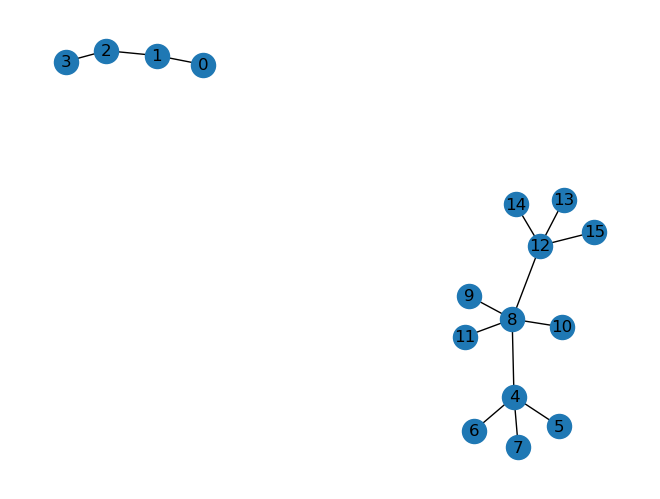

In [4]:
# from polymerist.polymers.monographs import MonomerGraph, MonomerGraphSerializer

G = MonomerGraph.from_smidge(targ_str)

nx.draw(G, with_labels=True)
# nx.draw(G, with_labels=True, labels=nx.get_node_attributes(G, G.MONOMER_NAME_ATTR))

[A][B][C][D].[J][I]([E]([A]([B])([C])[D])([F])([G])[H])([K])[L] 
 [A][B][C][D].[A]([B])([C])([D])[E]([F])([G])([H])[I]([J])([K])[L]


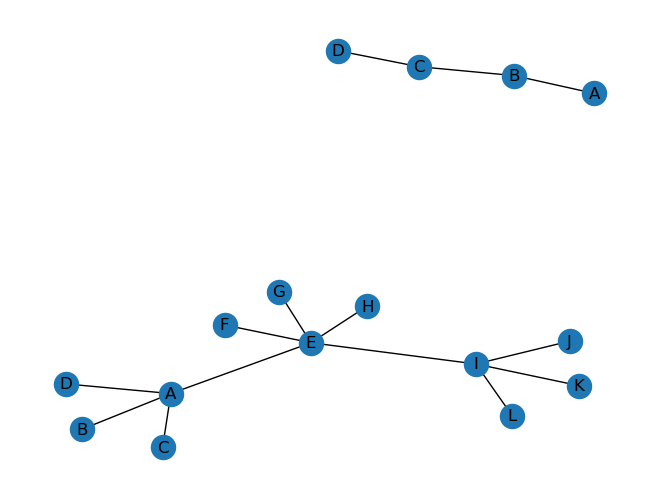

In [5]:
res = G.to_smidge(start_node_idxs=(0,13))
print(res, '\n', targ_str)

H = MonomerGraph.from_smidge(res)
# nx.draw(H, with_labels=True)
nx.draw(H, with_labels=True, labels=nx.get_node_attributes(H, H.MONOMER_NAME_ATTR))

In [6]:
G._passes_string_conversion_tests()

(True, None)

### "Alphabet" of monomer fragment chemical information 

In [7]:
from typing import Optional
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from dataclasses import dataclass, field


from polymerist.genutils.fileutils.jsonio.serialize import JSONSerializable, TypeSerializer, MultiTypeSerializer
from polymerist.genutils.fileutils.jsonio.jsonify import make_jsonifiable, JSONifiable
from polymerist.polymers.monographs import MonomerGraph, MonomerGraphSerializer
from polymerist.rdutils.bonding.portlib import get_num_linkers


@dataclass
class MonomerFragmentInfo:
    '''Naming and in-line chemical encodings for a monomer unit within a polymer chain'''
    name   : str
    smiles : str
    smarts   : Optional[str] = field(default=None)
    category : Optional[str] = field(default=None)

    n_atoms       : int = field(init=False)
    functionality : int = field(init=False)
    contribution  : int = field(init=False)

    def __post_init__(self) -> None:
        tempmol = self.rdmol
        self.n_atoms = tempmol.GetNumAtoms()
        self.functionality = get_num_linkers(tempmol)
        self.contribution = self.n_atoms - self.functionality

    @property
    def rdmol(self) -> Chem.Mol:
        return Chem.MolFromSmiles(self.smiles, sanitize=False)

class MonomerFragmentInfoSerializer(TypeSerializer):
    python_type = MonomerFragmentInfo

    @staticmethod
    def encode(python_obj : MonomerFragmentInfo) -> dict[str, JSONSerializable]:
        return python_obj.__dict__

    @staticmethod
    def decode(json_obj : dict[str, JSONSerializable]) -> MonomerFragmentInfo:
        params = {k : v for k, v in json_obj.items() if k not in ('n_atoms', 'functionality', 'contribution')}
        return MonomerFragmentInfo(**params)

Ser = MultiTypeSerializer(MonomerGraphSerializer, MonomerFragmentInfoSerializer)
@make_jsonifiable(type_serializer=Ser)
@dataclass
class PolymerStructure:
    '''Encodes a multi-scale structural representation of a polymer topology'''
    monoinfo  : dict[str, MonomerFragmentInfo]
    monograph : MonomerGraph


    @property
    def node_info_map(self) -> dict[int, MonomerFragmentInfo]:
        '''Map from node indices to relevant monomer information'''
        return {
            node_id : self.monoinfo[alias]
                for node_id, alias in nx.get_node_attributes(self.monograph, self.monograph.MONOMER_NAME_ATTR).items()
        }

    def chem_info_is_compatible(self) -> bool:
        '''Validate whether the chemical information for monomer fragments is compatible with the structural graph'''
        if set(self.monoinfo.keys()) != self.monograph.unique_monomer_names:
            return False
        
        for node_id, degree in self.monograph.degree:
            if (degree != self.node_info_map[node_id].functionality):
                return False
        
        return True

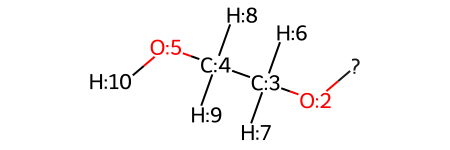

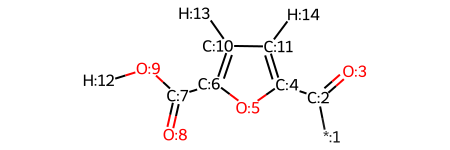

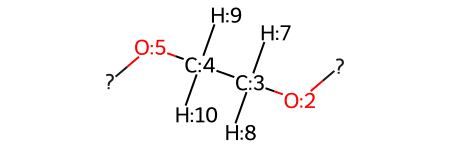

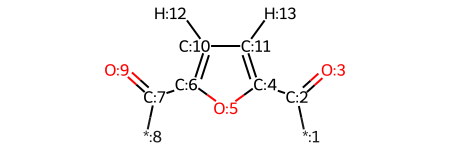

In [8]:
from polymerist.monomers import MonomerGroup
from string import ascii_uppercase

parent_monomers = {
    'ethane-1,2-diol' : 'OCCO',
    'furan-2,5-dicarboxylic acid' : 'O=C(O)c1ccc(C(=O)O)o1',
}
monomer_aliases = {
    mononame : lett
        for mononame, lett in zip(parent_monomers.keys(), ascii_uppercase)
}

monogrp = MonomerGroup.from_file('poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic acid).json')
moldict, monosmiles = {}, {}
for mononame, rdmol in monogrp.iter_rdmols():
    display(rdmol)
    moldict[   mononame] = rdmol
    monosmiles[mononame] = Chem.MolToSmiles(rdmol)

In [9]:
from polymerist.monomers import specification

mono_infos = {}
for mononame, smiles in monosmiles.items():
    parent_mononame = mononame.split('_')[0]
    parent_smiles = parent_monomers[parent_mononame]
    parent_alias  = monomer_aliases[parent_mononame]

    mono_info = MonomerFragmentInfo(
        name=mononame,
        smiles=smiles,
        smarts=specification.compliant_mol_SMARTS(smiles),
        category=parent_smiles,
    )
    alias = parent_alias.lower() if (mono_info.functionality == 1) else parent_alias.upper()
    mono_infos[alias] = mono_info
mono_infos

/home/timber/Documents/Python/polymerist_dev/polymerist/polymerist/monomers/specification.py:126: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  LOGGER.warn(f'Cleaned {num_repl} SMARTS atom query aberrations introduced by RDKit')
Cleaned 10 SMARTS atom query aberrations introduced by RDKit
/home/timber/Documents/Python/polymerist_dev/polymerist/polymerist/monomers/specification.py:126: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  LOGGER.warn(f'Cleaned {num_repl} SMARTS atom query aberrations introduced by RDKit')
Cleaned 14 SMARTS atom query aberrations introduced by RDKit
/home/timber/Documents/Python/polymerist_dev/polymerist/polymerist/monomers/specification.py:126: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  LOGGER.warn(f'Cleaned {num_repl} SMARTS atom query aberrations introduced by RDKit')
Cleaned 10 SMARTS atom query aberrations introduced by RDKit
/home/timber/Documents/Python/polymer

{'a': MonomerFragmentInfo(name='ethane-1,2-diol_TERM', smiles='[2*:1][O:2][C:3]([C:4]([O:5][H:10])([H:8])[H:9])([H:6])[H:7]', smarts='[2*:1]-[#8D2+0:2]-[#6D4+0:3](-[#6D4+0:4](-[#8D2+0:5]-[#1D1+0:10])(-[#1D1+0:8])-[#1D1+0:9])(-[#1D1+0:6])-[#1D1+0:7]', category='OCCO', n_atoms=10, functionality=1, contribution=9),
 'b': MonomerFragmentInfo(name='furan-2,5-dicarboxylic acid_TERM', smiles='[*:1][C:2](=[O:3])[C:4]1=[C:11]([H:14])[C:10]([H:13])=[C:6]([C:7](=[O:8])[O:9][H:12])[O:5]1', smarts='[*:1]-[#6D3+0:2](=[#8D1+0:3])-[#6D3+0:4]1=[#6D3+0:11](-[#1D1+0:14])-[#6D3+0:10](-[#1D1+0:13])=[#6D3+0:6](-[#6D3+0:7](=[#8D1+0:8])-[#8D2+0:9]-[#1D1+0:12])-[#8D2+0:5]-1', category='O=C(O)c1ccc(C(=O)O)o1', n_atoms=14, functionality=1, contribution=13),
 'A': MonomerFragmentInfo(name='ethane-1,2-diol_MID', smiles='[2*:1][O:2][C:3]([C:4]([O:5][2*:6])([H:9])[H:10])([H:7])[H:8]', smarts='[2*:1]-[#8D2+0:2]-[#6D4+0:3](-[#6D4+0:4](-[#8D2+0:5]-[2*:6])(-[#1D1+0:9])-[#1D1+0:10])(-[#1D1+0:7])-[#1D1+0:8]', category='OC

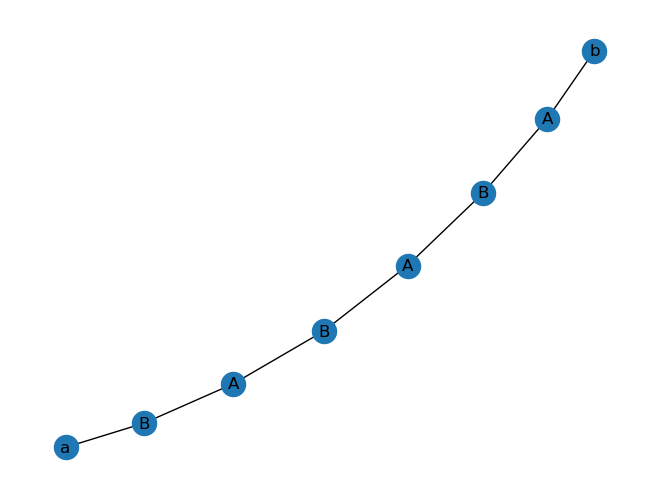

In [10]:
import networkx as nx
from polymerist.genutils.textual import delimiters
from polymerist.polymers.monographs import MonomerGraph


smidge = delimiters.square_brackets_around_letters('aBABABAb')
monograph = MonomerGraph.from_smidge(smidge)
monograph.draw()

poly = PolymerStructure(
    monoinfo=mono_infos,
    monograph=monograph
)

In [11]:
poly.to_file('test.json')

In [12]:
p = PolymerStructure.from_file('test.json')

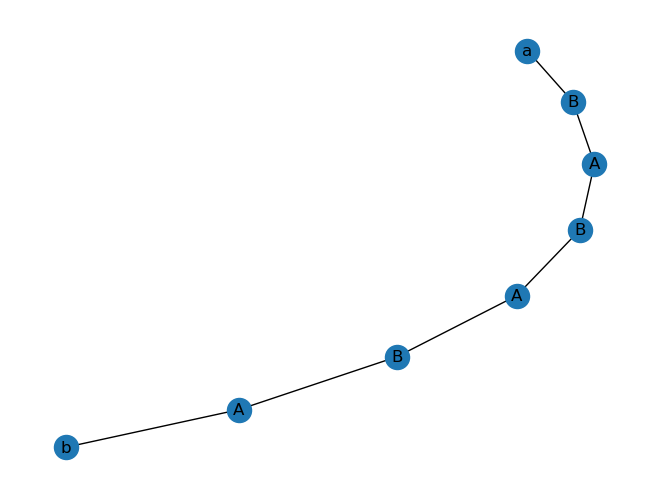

In [13]:
p.monograph.draw()

In [14]:
poly.chem_info_is_compatible()

True

## Playing with ratios

In [ ]:
from dataclasses import dataclass
from typing import Any, Callable, ClassVar, TypeVar
from math import gcd
from numbers import Number


N = TypeVar('N')
def sgnmag(num : N) -> tuple[bool, N]:
    '''Returns the sign and magnitude of a numeric-like value'''
    return num < 0, abs(num)


@dataclass(repr=False)
class Ratio:
    '''For representing fractional ratios between two objects'''
    num   : Any
    denom : Any

    # REPRESENTATION
    def __repr__(self) -> str:
        return f'{self.num}/{self.denom}'
    
    def to_latex(self) -> str:
        '''Return latex-compatible string which represent fraction'''
        return rf'\frac{{{self.num}}}{{{self.denom}}}'

    # RELATIONS
    @property
    def reciprocal(self) -> 'Ratio':
        '''Return the reciprocal of a ration'''
        return self.__class__(self.denom, self.num)


@dataclass(repr=False)
class Rational(Ratio):
    '''For representing ratios of integers'''
    num   : int
    denom : int

    # REDUCTION
    autoreduce : ClassVar[bool]=False
    
    def __post_init__(self) -> None:
        if self.__class__.autoreduce:
            self.reduce()

    def reduce(self) -> None:
        '''Reduce numerator and denominator by greatest common factor'''
        _gcd = gcd(self.num, self.denom)
        self.num=int(self.num / _gcd)
        self.denom=int(self.denom / _gcd)
    simplify = reduce # alias for convenience

    @property
    def reduced(self) -> 'Rational':
        '''Return reduced Rational equivalent to the current rational (does not modify in-place)'''
        new_rat = self.__class__(self.num, self.denom)
        new_rat.reduce()

        return new_rat
    simplifed = reduced # alias for convenience
    
    def as_proper(self) -> tuple[int, 'Rational']:
        '''Returns the integer and proper fractional component of a ratio'''
        integ, remain = divmod(self.num, self.denom)
        return integ, self.__class__(remain, self.denom)
    
    # ARITHMETIC
    def __add__(self, other : 'Rational') -> 'Rational':
        '''Sum of two Rationals'''
        return self.__class__(
            num=(self.num * other.denom) + (self.denom * other.num),
            denom=(self.denom * other.denom)
        )
    
    def __sub__(self, other : 'Rational') -> 'Rational':
        '''Difference of two Rationals'''
        return self.__class__(
            num=(self.num * other.denom) - (self.denom * other.num),
            denom=(self.denom * other.denom)
        )

    def __mul__(self, other : 'Rational') -> 'Rational':
        '''Product of two Rationals'''
        return self.__class__(
            num=self.num * other.num,
            denom=self.denom * other.denom
        )

    def __div__(self, other : 'Rational') -> 'Rational':
        '''Quotient of two Rationals'''
        return self.__class__(
            num=self.num * other.denom,
            denom=self.denom * other.num
        )
    
    def __pow__(self, power : float) -> 'Rational':
        '''Exponentiates a ratio'''
        return self.__class__(
            num=self.num**power,
            denom=self.denom**power
        )

In [ ]:
p = Rational(3, 6)
q = Rational(4, 12)

print(p, p.reciprocal, p.reduced, p+q)

In [ ]:
Rational.autoreduce = False

In [ ]:
import numpy as np
from numbers import Number

for val in (4, 4.0, 4+0j, np.pi, '4', [4], False, 'sgdfg'):
    print(val, type(val), isinstance(val, Number))

In [ ]:
from fractions import Fraction